In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/content/drive/Shared drives/SIH2020/Dataset/drone.csv')
df.head()

,RF,Time,Latitude,Longitude,Altitude
0,1,10:45:16,22.902930,120.273135,20.963
1,1,10:45:18,22.902884,120.273094,20.579
2,1,10:45:21,22.902798,120.273022,20.244
3,1,10:45:23,22.902714,120.272959,20.488
4,1,10:45:26,22.902689,120.272916,21.256


In [3]:
#df.rename(columns={'Altitude (m masl GPS)':'Altitude'},inplace=True)
data = df[['Latitude','Longitude','Altitude']]
data.head(12)

,Latitude,Longitude,Altitude
0,22.902930,120.273135,20.963
1,22.902884,120.273094,20.579
2,22.902798,120.273022,20.244
3,22.902714,120.272959,20.488
4,22.902689,120.272916,21.256
5,22.902708,120.272892,21.465
6,22.902806,120.272771,20.263
7,22.902866,120.272687,20.265
8,22.902912,120.272633,19.762
9,22.902919,120.272623,19.588


In [4]:
final = pd.DataFrame()
for i in range(-5,0,1):
  print(i)
  new = data.shift(i,axis=0)
  final = pd.concat([final,new],axis=1)

final = pd.concat([data,final],axis=1)
#new.rename(columns={'Latitude':'Label_Latitude','Longitude':'Label_Longitude','Altitude':'Label_Altitude'},inplace=True)
#new.head()
final.head()

-5
-4
-3
-2
-1


,Latitude,Longitude,Altitude,Latitude,Longitude,Altitude,Latitude,Longitude,Altitude,Latitude,Longitude,Altitude,Latitude,Longitude,Altitude,Latitude,Longitude,Altitude
0,22.902930,120.273135,20.963,22.902708,120.272892,21.465,22.902689,120.272916,21.256,22.902714,120.272959,20.488,22.902798,120.273022,20.244,22.902884,120.273094,20.579
1,22.902884,120.273094,20.579,22.902806,120.272771,20.263,22.902708,120.272892,21.465,22.902689,120.272916,21.256,22.902714,120.272959,20.488,22.902798,120.273022,20.244
2,22.902798,120.273022,20.244,22.902866,120.272687,20.265,22.902806,120.272771,20.263,22.902708,120.272892,21.465,22.902689,120.272916,21.256,22.902714,120.272959,20.488
3,22.902714,120.272959,20.488,22.902912,120.272633,19.762,22.902866,120.272687,20.265,22.902806,120.272771,20.263,22.902708,120.272892,21.465,22.902689,120.272916,21.256
4,22.902689,120.272916,21.256,22.902919,120.272623,19.588,22.902912,120.272633,19.762,22.902866,120.272687,20.265,22.902806,120.272771,20.263,22.902708,120.272892,21.465


In [5]:
final.shape

(3530, 18)

In [6]:
print(final.shape)
final.dropna(inplace=True)
print(final.shape)

(3530, 18)
(3502, 18)


In [7]:
values = final.values
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
X = values[:,:final.shape[1]-3]
Y = values[:,final.shape[1]-3:]

In [8]:
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size=1000,shuffle=False)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(2502, 15) (1000, 15) (2502, 3) (1000, 3)


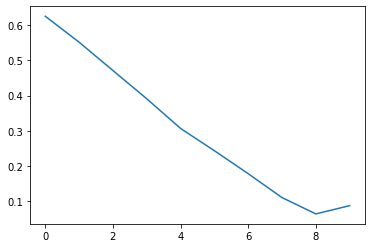

(10, 15)

In [9]:
g = pd.DataFrame(X_test)
z = g.iloc[20:30,1]
t = np.arange(10)
plt.plot(t,z)
plt.show()
X_test[:10].shape

In [10]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))


In [11]:
def create_model():
  model = Sequential()
  model.add(LSTM(50, input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dense(3))
  return model


In [12]:
def train_model(filepath):
  model = create_model()
  model.compile(loss='mae', optimizer='adam')
  # fit network
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
  history = model.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=2, shuffle=False,callbacks=[checkpoint])
  return history

In [14]:
filepath = '/content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_timestep.hdf5'
history = train_model(filepath)

Train on 2502 samples, validate on 1000 samples
Epoch 1/30
 - 1s - loss: 0.3880 - val_loss: 0.1797

Epoch 00001: val_loss improved from inf to 0.17971, saving model to /content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_timestep.hdf5
Epoch 2/30
 - 0s - loss: 0.1532 - val_loss: 0.1365

Epoch 00002: val_loss improved from 0.17971 to 0.13650, saving model to /content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_timestep.hdf5
Epoch 3/30
 - 0s - loss: 0.1225 - val_loss: 0.1247

Epoch 00003: val_loss improved from 0.13650 to 0.12471, saving model to /content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_timestep.hdf5
Epoch 4/30
 - 0s - loss: 0.0999 - val_loss: 0.1053

Epoch 00004: val_loss improved from 0.12471 to 0.10528, saving model to /content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_timestep.hdf5
Epoch 5/30
 - 0s - loss: 0.0796 - val_loss: 0.0895

Epoch 00005: val_loss improved from 0.10528 to 0.08953, saving model to /content/drive/S

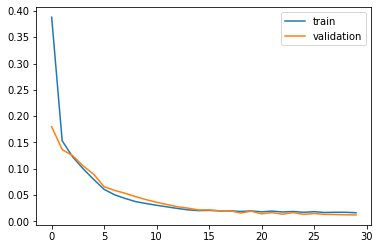

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [19]:
model = create_model()
model.load_weights(filepath)

yhat = model.predict(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[2]))

yhat = np.concatenate((yhat,X_test),axis=1)
inv_yhat = scaler.inverse_transform(yhat)

Y_test = np.concatenate((Y_test,X_test),axis=1)
inv_y = scaler.inverse_transform(Y_test)

d1 = pd.DataFrame(inv_yhat)
d2 = pd.DataFrame(inv_y)

inv_yhat = d1.iloc[:,:3]
inv_y = d2.iloc[:,:3]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
#rmse = math.sqrt(mean_squared_error(yhat,Y_test))
print('Test RMSE: %.3f' % rmse)

ValueError: ignored

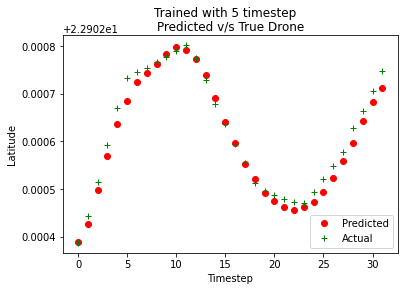

In [25]:
t = np.arange(32)
x_pred = d1.iloc[:32,0]
x_true = d2.iloc[:32,0]
plt.plot(t,x_pred,'ro', label ='Predicted') 
plt.plot(t,x_true,'g+', label ='Actual')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Latitude')
plt.title('Predicted v/s True Drone')
plt.suptitle('Trained with 5 timestep')
plt.savefig('/content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_lat_vs_time.png')
plt.show()

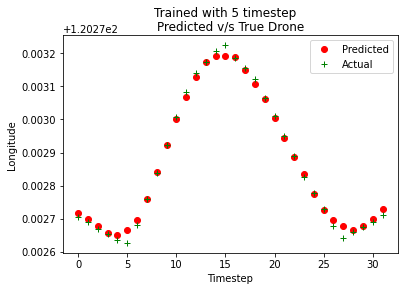

In [26]:
t = np.arange(32)
x_pred = d1.iloc[:32,1]
x_true = d2.iloc[:32,1]
plt.plot(t,x_pred,'ro', label ='Predicted') 
plt.plot(t,x_true,'g+', label ='Actual')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Longitude')
plt.title('Predicted v/s True Drone')
plt.suptitle('Trained with 5 timestep')
plt.savefig('/content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_lon_vs_time.png')
plt.show()

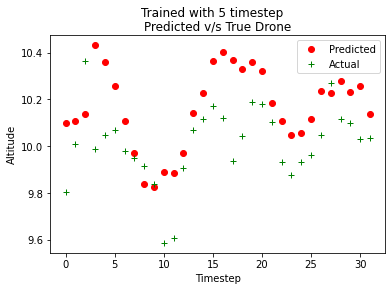

In [27]:
t = np.arange(32)
x_pred = d1.iloc[:32,2]
x_true = d2.iloc[:32,2]
plt.plot(t,x_pred,'ro', label ='Predicted') 
plt.plot(t,x_true,'g+', label ='Actual')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Altitude')
plt.title('Predicted v/s True Drone')
plt.suptitle('Trained with 5 timestep')
plt.savefig('/content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_alt_vs_time.png')
plt.show()

In [ ]:
#Trajectory Test
sample = X_test[0]
print(sample.shape)
result = [sample]
sample = np.reshape(X_test[0],(1,10,3))

for i in range(10):
  sample = model.predict(sample)
  result.append(np.reshape(sample,(10,3)))
  sample = np.reshape(sample,(1,10,3))
  
f = pd.DataFrame(np.array(result))
t = np.arange(11)
plt.plot(t,f[0],'r-', label ='Trajectory Lat') 
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Latitude')
plt.title('Trajectory Latitude')
plt.savefig('/content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_traj_time.png')
plt.show()



plt.plot(t,f[1],'b-', label ='Trajectory Lon') 
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Longitude')
plt.title('Trajectory Longitude')
plt.savefig('/content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_traj_lon.png')
plt.show()



plt.plot(t,f[2],'g-', label ='Trajectory Alt') 
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Altitude')
plt.title('Trajectory Altitude')
plt.savefig('/content/drive/Shared drives/SIH2020/lstm_drone_5_timestep/lstm_5_traj_alt.png')
plt.show()







(10, 15)


ValueError: ignored